<a href="https://colab.research.google.com/github/GurashishJuneja/MMAI831-Finance/blob/main/Assignment_3_MMAI823_Question_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Long Short Term Memory 



1. Import the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math

import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


2. Download the data from yahoo. We use ANZN

In [ ]:
import importlib.util
package_name = 'yfinance'
spec = importlib.util.find_spec(package_name)
if spec is None:
    print(package_name +" is not installed")
    !pip install yfinance

import yfinance as yf
df=yf.download(['AMZN', 'GOOG'], start='2012-01-01', end='2023-02-10')

df

[*********************100%***********************]  2 of 2 completed


Adj Close                   Close                    High  \
                  AMZN        GOOG        AMZN        GOOG        AMZN   
Date                                                                     
2012-01-03    8.951500   16.573130    8.951500   16.573130    8.974000   
2012-01-04    8.875500   16.644611    8.875500   16.644611    9.025000   
2012-01-05    8.880500   16.413727    8.880500   16.413727    8.912500   
2012-01-06    9.130500   16.189817    9.130500   16.189817    9.232500   
2012-01-09    8.928000   15.503389    8.928000   15.503389    9.218500   
...                ...         ...         ...         ...         ...   
2023-02-03  103.389999  105.220001  103.389999  105.220001  108.779999   
2023-02-06  102.180000  103.470001  102.180000  103.470001  103.949997   
2023-02-07  102.110001  108.040001  102.110001  108.040001  102.410004   
2023-02-08  100.050003  100.000000  100.050003  100.000000  102.669998   
2023-02-09   98.239998   95.459999   98.239998   95.459999  101.779999   

                               Low                    Open              \
                  GOOG        AMZN        GOOG        AMZN        GOOG   
Date                                                                     
2012-01-03   16.641375    8.777500   16.248346    8.794500   16.262545   
2012-01-04   16.693678    8.803500   16.453827    8.960500   16.563665   
2012-01-05   16.537264    8.702500   16.344486    8.797000   16.491436   
2012-01-06   16.438385    8.875000   16.184088    8.903500   16.417213   
2012-01-09   16.114599    8.850000   15.472754    9.138000   16.102144   
...                ...         ...         ...         ...         ...   
2023-02-03  108.019997  102.519997  103.300003  105.260002  103.510002   
2023-02-06  104.699997  100.650002  102.209999  102.930000  102.684998   
2023-02-07  108.669998   98.080002  103.547997  101.169998  103.629997   
2023-02-08  103.580002   98.779999   98.455002  102.040001  102.690002   
2023-02-09  100.610001   97.570000   93.860001  101.320000  100.540001   

               Volume             
                 AMZN       GOOG  
Date                              
2012-01-03  102216000  147611217  
2012-01-04   84104000  114989399  
2012-01-05   76182000  131808205  
2012-01-06  140168000  108119746  
2012-01-09  101138000  233776981  
...               ...        ...  
2023-02-03  144374800   36823400  
2023-02-06   81945200   25573000  
2023-02-07  119501300   33738800  
2023-02-08   75878300   73546000  
2023-02-09   64622500   97798600  

[2795 rows x 12 columns]

In [ ]:
df.shape

(2795, 12)

3. Visualize

In [ ]:
df['Close'].tail(10)

,AMZN,GOOG
Date,,
2023-01-27,102.239998,100.709999
2023-01-30,100.550003,97.949997
2023-01-31,103.129997,99.870003
2023-02-01,105.150002,101.430000
2023-02-02,112.910004,108.800003
2023-02-03,103.389999,105.220001
2023-02-06,102.180000,103.470001
2023-02-07,102.110001,108.040001
2023-02-08,100.050003,100.000000


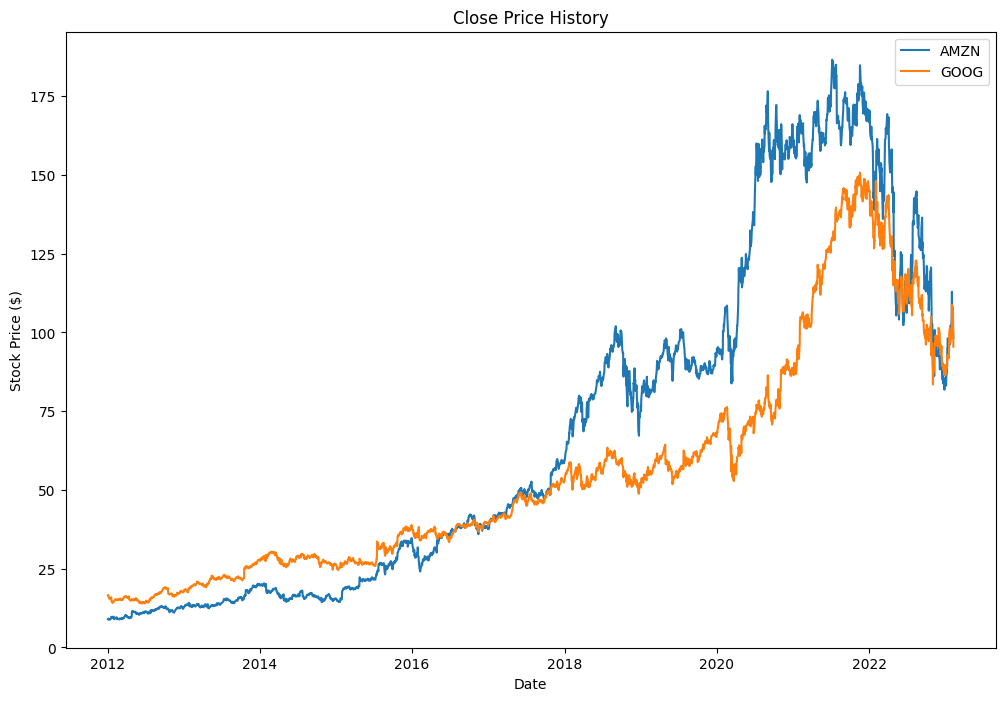

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend(['AMZN', 'GOOG'])

In [ ]:
data=df['Close']
data.head(20)

,AMZN,GOOG
Date,,
2012-01-03,8.9515,16.573130
2012-01-04,8.8755,16.644611
2012-01-05,8.8805,16.413727
2012-01-06,9.1305,16.189817
2012-01-09,8.9280,15.503389
2012-01-10,8.9670,15.520326
2012-01-11,8.9450,15.590563
2012-01-12,8.7965,15.682219
2012-01-13,8.9210,15.566403


4. Prepare the data

In [ ]:
#convert to numpy array
#We use 80 of the data for training
train_pct=0.8  
dataset=data.values
train_data_len=math.ceil(len(dataset)*train_pct)

In [ ]:
dataset.shape

(2795, 2)

In [ ]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

In [ ]:
scaled_data.shape

(2795, 2)

### The window we use is n_period as input

In [ ]:
n_period=60
n_future = 5 # Number of future days to predict

#training dataset
train_data=scaled_data[0:train_data_len]
x_train=[]
y_train=[]

for i in range(n_period, len(train_data) - n_future + 1):
    x_train.append(train_data[i-n_period:i])
    y_train.append(train_data[i: i+n_future,0])

#Converting x_train to a numpy array and reshape

x_train = np.array(x_train).reshape(-1, n_period, 2) #given we have two stocks(AMZN & GOOG)
    


In [ ]:
x_train[0:1]

array([[[0.00087189, 0.01936668],
        [0.00044438, 0.01988927],
        [0.00047251, 0.01820133],
        [0.00187879, 0.01656439],
        [0.0007397 , 0.01154608],
        [0.00095908, 0.0116699 ],
        [0.00083533, 0.01218339],
        [0.        , 0.01285346],
        [0.00070032, 0.01200676],
        [0.0016116 , 0.01266045],
        [0.00379977, 0.01344889],
        [0.00520886, 0.01466158],
        [0.00421884, 0.0049054 ],
        [0.00285756, 0.00481982],
        [0.0031135 , 0.00398405],
        [0.00333851, 0.00190098],
        [0.00489104, 0.00164788],
        [0.00546762, 0.00381107],
        [0.00456197, 0.00339409],
        [0.00520605, 0.00383474],
        [0.00099283, 0.00396584],
        [0.00162847, 0.00474516],
        [0.00330476, 0.00678818],
        [0.00202785, 0.0091116 ],
        [0.00232318, 0.00868915],
        [0.00268599, 0.00924998],
        [0.00254536, 0.00954313],
        [0.00270287, 0.00853256],
        [0.00440447, 0.00967788],
        [0.004

In [ ]:
y_train[0:1]

[array([0.00806642, 0.00747578, 0.00622138, 0.0066742 , 0.00507948])]

In [ ]:
y_train[:2]

[array([0.00806642, 0.00747578, 0.00622138, 0.0066742 , 0.00507948]),
 array([0.00747578, 0.00622138, 0.0066742 , 0.00507948, 0.00519198])]

In [ ]:
#Convert numpy array
x_train, y_train=np.array(x_train), np.array(y_train)

In [ ]:
x_train.shape

(2172, 60, 2)

In [ ]:
y_train.shape

(2172, 5)

In [ ]:
x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1],2))
x_train.shape

(2172, 60, 2)

5. Train the model
Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
loss function is chosen as mean_squared_error'

In [ ]:
#Build the LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
          

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(x_train,y_train, batch_size=1, epochs=1)

2172/2172 [==============================] - 70s 31ms/step - loss: 0.0012


In [ ]:
#Test

# Extract the portion of the test data for prediction
test_data=scaled_data[train_data_len-60:,:]

# Prepare the test inputs (similar to training)
x_test = []
y_test = []

for i in range(n_period, len(test_data) - n_future + 1):
    x_test.append(test_data[i-n_period:i])
    y_test.append(test_data[i:i+n_future, 0])

# Convert x_test to numpy array and reshape
x_test = np.array(x_test).reshape(-1, n_period, 2)  # Assuming I have 2 features (AMZN, GOOG)

In [ ]:
x_test.shape

(555, 60, 2)

6. Prediction error

In [ ]:
scaled_data

array([[8.71892048e-04, 1.93666841e-02],
       [4.44381751e-04, 1.98892687e-02],
       [4.72507993e-04, 1.82013303e-02],
       ...,
       [5.24899607e-01, 6.88057775e-01],
       [5.13311875e-01, 6.29279368e-01],
       [5.03130379e-01, 5.96088573e-01]])

In [ ]:
scaler.data_max_

array([186.57049561, 150.70899963])

In [ ]:
scaler.data_min_

array([ 8.79650021, 13.92405891])

In [ ]:
predictions_scaled=model.predict(x_test)

18/18 [==============================] - 1s 19ms/step


In [ ]:
#predictions=scaler.inverse_transform(predictions)
predictions=predictions_scaled*(scaler.data_max_[0]-scaler.data_min_[0])+scaler.data_min_[0]

In [ ]:
predictions.shape

(555, 1)

In [ ]:
#RMSE
rmse=np.sqrt(np.mean(predictions-y_test)**2)
rmse

126.95888439042683

In [ ]:
data.max()

AMZN    186.570496
GOOG    150.709000
dtype: float64

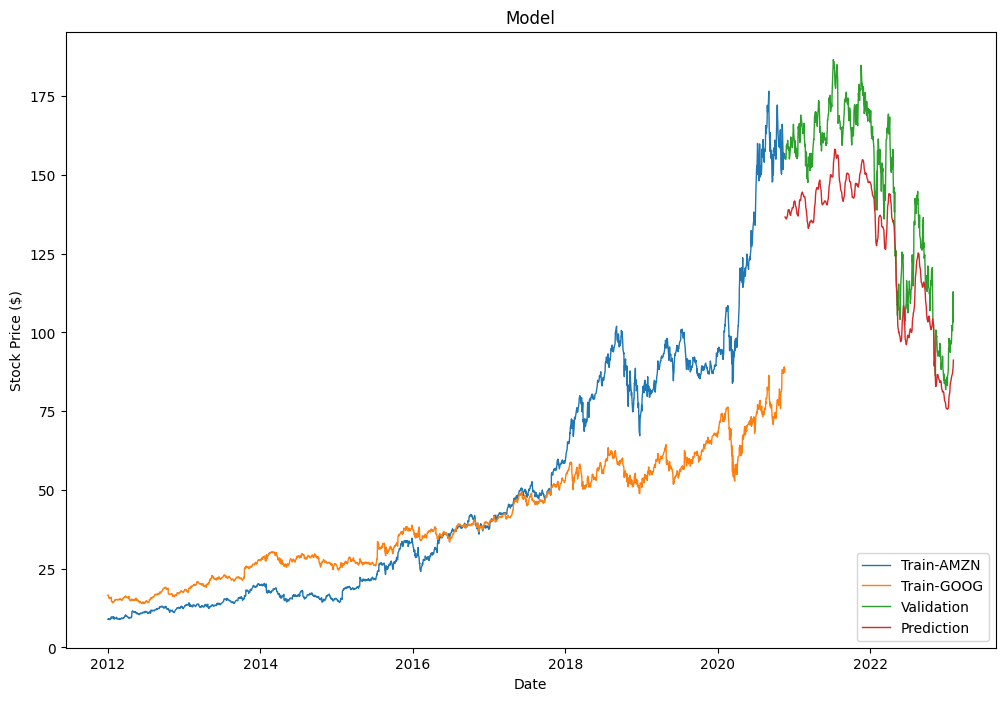

In [ ]:
#plot the result
train=data[:train_data_len]
valid=data[train_data_len: train_data_len + len(predictions)]
valid=valid.assign(Predictions=predictions)
plt.figure(figsize=(12,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.plot(train, lw=1)
plt.plot(valid[['AMZN','Predictions']], lw=1)
plt.legend(['Train-AMZN','Train-GOOG', 'Validation', 'Prediction'],loc='lower right')
plt.show()

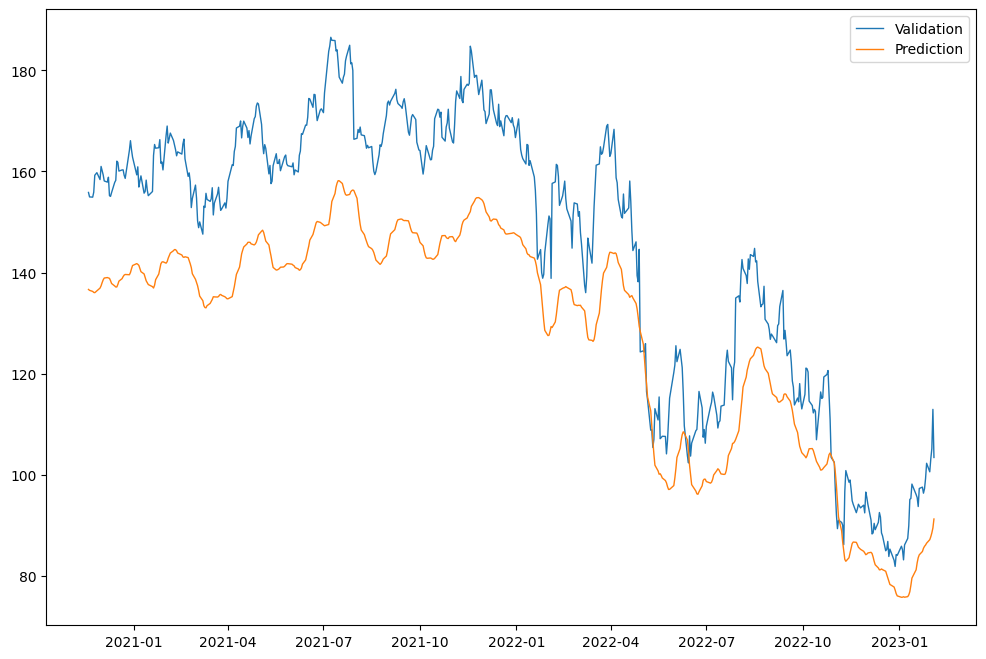

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(valid[['AMZN','Predictions']], lw=1)
plt.legend(['Validation', 'Prediction'])


Question: In the example, we use the last 60 day's price to predict the closing price for next day.  Modify the program to perform the following task:

a. Use past 60 days price to predict the price in one week (5 days). You can choose any stock. Also use two indices prices for input

b. Use your prediction to generate trading signals for the testing periodd (20% of you dataset):  if the predicted price is higher than the current price (you can specify a threshold) , you should buy one share; if it is lower than the current price, you can short one share.

c. Assume that you will always close your position in onw week, caculate your accumaltaed PnL for testing data

d. Repeat. a) - c), adding S&P500 to the features for the prediction (as I explained in the class).

e. Repeat: a)-c), adding S&P 500 and the VIX index to the features for the predcition( as explained in class).

a. Use past 60 days price to predict the price in one week (5 days). You can choose any stock. 

In [ ]:
amzn_predicted_prices = predictions[-n_future:, 0]  # Selecting only the AMZN stock predictions
for i, price in enumerate(amzn_predicted_prices, start=1):
    print(f"Day {i}: Predicted price for AMZN stock: {price}")

Day 1: Predicted price for AMZN stock: 87.11370849609375
Day 2: Predicted price for AMZN stock: 87.70365905761719
Day 3: Predicted price for AMZN stock: 88.45941925048828
Day 4: Predicted price for AMZN stock: 89.42697143554688
Day 5: Predicted price for AMZN stock: 91.20911407470703


b. Use your prediction to generate trading signals for the testing periodd (20% of you dataset): if the predicted price is higher than the current price (you can specify a threshold) , you should buy one share; if it is lower than the current price, you can short one share.

ASSUMPTION: WILL BE USING THE AMZN STOCK FOR THIS

In [ ]:
# Extract the 'Close' price for the AMZN stock
amzn_prices = df['Close']['AMZN']

# Get the current price
amzn_current_prices = amzn_prices.iloc[-1]

print("Current Price @ AMZN: $", amzn_current_prices)

Current Price @ AMZN: $ 98.23999786376953


In [ ]:
threshold = 0.05 #the threshold has been specified as 5% movement up or down # assumption

#getting the last n_future predictions

amzn_predicted_prices = predictions[-n_future:,0]

#replicating current prices to match the length of predicted prices

amzn_current_price = np.full(amzn_predicted_prices.shape, amzn_current_prices)

# Loop through the predicted prices and generate trading signals

for i, amzn_predicted_price in enumerate(amzn_predicted_prices, start=1):

    if np.any(amzn_predicted_price > amzn_current_price * (1 + threshold)):

        # Buy one share

        print("Buy one share on day", i)

    elif np.any (amzn_predicted_price < amzn_current_price * (1 - threshold)):

        # Short one share

        print("Short one share on day", i)

    else:

        # Hold or take no action
        
        print("Hold or take no action on day", i)






Short one share on day 1
Short one share on day 2
Short one share on day 3
Short one share on day 4
Short one share on day 5


c. Assume that you will always close your position in one week, calculate your accumaltaed PnL for testing data

In [ ]:
# Initialize variables
position = 0

capital = 10000  # Starting capital

pnls = []

# Loop through the testing period

for i, amzn_predicted_price in enumerate(amzn_predicted_prices, start=1):

    # Check trading signal

    if np.any(amzn_predicted_price > amzn_current_price * (1 + threshold)):

        # Buy one share

        if np.any(position == 0):

            shares_to_buy = capital // amzn_current_price

            position += shares_to_buy

            capital -= shares_to_buy * amzn_current_price
            
    elif np.any(amzn_predicted_price < amzn_current_price * (1 - threshold)):
        # Short one share
        if np.any(position > 0):
            shares_to_sell = position
            position -= shares_to_sell
            capital += shares_to_sell * amzn_current_price

    # Calculate PnL for current trade
    pnl = (position * amzn_current_price) - 10000
    pnls.append(pnl)

# Calculate accumulated PnL
accumulated_pnl = np.sum(pnls)

print("Accumulated PnL:", accumulated_pnl)


Accumulated PnL: -250000.0


d. Repeat. a) - c), adding S&P500 to the features for the prediction (as I explained in the class).

In [ ]:
#Starting all over

tickers = ["^GSPC"]

start_date = '2012-01-01'
end_date = '2023-02-10'

df = yf.download(tickers, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,1258.859985,1284.619995,1258.859985,1277.060059,1277.060059,3943710000
2012-01-04,1277.030029,1278.729980,1268.099976,1277.300049,1277.300049,3592580000
2012-01-05,1277.300049,1283.050049,1265.260010,1281.060059,1281.060059,4315950000
2012-01-06,1280.930054,1281.839966,1273.339966,1277.810059,1277.810059,3656830000
2012-01-09,1277.829956,1281.989990,1274.550049,1280.699951,1280.699951,3371600000
...,...,...,...,...,...,...
2023-02-03,4136.689941,4182.359863,4123.359863,4136.479980,4136.479980,4694510000
2023-02-06,4119.569824,4124.629883,4093.379883,4111.080078,4111.080078,4114240000
2023-02-07,4105.350098,4176.540039,4088.389893,4164.000000,4164.000000,4355860000


In [ ]:
df.shape

(2795, 6)

In [ ]:
df["Close"].tail(10)

Date
2023-01-27    4070.560059
2023-01-30    4017.770020
2023-01-31    4076.600098
2023-02-01    4119.209961
2023-02-02    4179.759766
2023-02-03    4136.479980
2023-02-06    4111.080078
2023-02-07    4164.000000
2023-02-08    4117.859863
2023-02-09    4081.500000
Name: Close, dtype: float64

In [ ]:
df["Adj Close"]

Date
2012-01-03    1277.060059
2012-01-04    1277.300049
2012-01-05    1281.060059
2012-01-06    1277.810059
2012-01-09    1280.699951
                 ...     
2023-02-03    4136.479980
2023-02-06    4111.080078
2023-02-07    4164.000000
2023-02-08    4117.859863
2023-02-09    4081.500000
Name: Adj Close, Length: 2795, dtype: float64

In [ ]:
sp500_prices = df[["Close","Adj Close"]]

In [ ]:
sp500_prices.head()

,Close,Adj Close
Date,,
2012-01-03,1277.060059,1277.060059
2012-01-04,1277.300049,1277.300049
2012-01-05,1281.060059,1281.060059
2012-01-06,1277.810059,1277.810059
2012-01-09,1280.699951,1280.699951


In [ ]:
#convert to numpy array
#We use 80 of the data for training
train_pct=0.8  
dataset= sp500_prices.values
train_data_len=math.ceil(len(dataset)*train_pct)

In [ ]:
dataset.shape

(2795, 2)

In [ ]:
#scaling the data

scaler = MinMaxScaler(feature_range =(0,1))

scaled_data= scaler.fit_transform(dataset)

scaled_data.shape

(2795, 2)

In [ ]:
n_period = 60
n_future = 5  # Number of future days to predict

# Training dataset
train_data = scaled_data[0:train_data_len]
x_train = []
y_train = []

for i in range(n_period, len(train_data) - n_future + 1):
    x_train.append(train_data[i - n_period:i, :])  # Adjust the number of columns based on the number of features
    y_train.append(train_data[i:i + n_future, 0])  # Use the appropriate column index for the target variable

# Convert x_train to numpy array and reshape
x_train = np.array(x_train).reshape(-1, n_period, 2)  # Replace num_features with the actual number of features


In [ ]:
x_train

array([[[0.00000000e+00, 0.00000000e+00],
        [6.81887298e-05, 6.81887298e-05],
        [1.13652507e-03, 1.13652507e-03],
        ...,
        [3.96220915e-02, 3.96220915e-02],
        [3.84884106e-02, 3.84884106e-02],
        [3.65051798e-02, 3.65051798e-02]],

       [[6.81887298e-05, 6.81887298e-05],
        [1.13652507e-03, 1.13652507e-03],
        [2.13098451e-04, 2.13098451e-04],
        ...,
        [3.84884106e-02, 3.84884106e-02],
        [3.65051798e-02, 3.65051798e-02],
        [3.58630404e-02, 3.58630404e-02]],

       [[1.13652507e-03, 1.13652507e-03],
        [2.13098451e-04, 2.13098451e-04],
        [1.03420730e-03, 1.03420730e-03],
        ...,
        [3.65051798e-02, 3.65051798e-02],
        [3.58630404e-02, 3.58630404e-02],
        [3.73376650e-02, 3.73376650e-02]],

       ...,

       [[5.98076412e-01, 5.98076412e-01],
        [6.00289806e-01, 6.00289806e-01],
        [5.96047745e-01, 5.96047745e-01],
        ...,
        [6.34575904e-01, 6.34575904e-01],
     

In [ ]:
#Converting into numpy array

x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
x_train.shape

(2172, 60, 2)

In [ ]:
y_train.shape

(2172, 5)

In [ ]:
x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1],2))
x_train.shape

(2172, 60, 2)

#Building the LTSM model

In [ ]:
#Build the LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(x_train,y_train, batch_size=1, epochs=1)

2172/2172 [==============================] - 71s 31ms/step - loss: 6.5829e-04


In [ ]:
# Test data
test_data = scaled_data[train_data_len - n_period:, :]  # Extract the portion of the test data for prediction

# Prepare the test inputs (similar to training)
x_test = []
y_test = []

for i in range(n_period, len(test_data) - n_future + 1):
    x_test.append(test_data[i - n_period:i, :])  # Adjust the number of columns based on the number of features
    y_test.append(test_data[i:i + n_future, 0])  # Use the appropriate column index for the target variable

# Convert x_test to numpy array and reshape
x_test = np.array(x_test).reshape(-1, n_period,2)  


In [ ]:
x_test.shape

(555, 60, 2)

In [ ]:
scaled_data

array([[0.00000000e+00, 0.00000000e+00],
       [6.81887298e-05, 6.81887298e-05],
       [1.13652507e-03, 1.13652507e-03],
       ...,
       [8.20269908e-01, 8.20269908e-01],
       [8.07160052e-01, 8.07160052e-01],
       [7.96829078e-01, 7.96829078e-01]])

In [ ]:
scaler.data_max_

array([4796.56005859, 4796.56005859])

In [ ]:
scaler.data_min_

array([1277.06005859, 1277.06005859])

In [ ]:
predictions_scaled=model.predict(x_test)

18/18 [==============================] - 2s 35ms/step


In [ ]:
#predictions=scaler.inverse_transform(predictions)
predictions=predictions_scaled*(scaler.data_max_[0]-scaler.data_min_[0])+scaler.data_min_[0]

In [ ]:
predictions.shape

(555, 1)

In [ ]:
#RMSE
rmse=np.sqrt(np.mean(predictions-y_test)**2)
rmse

4025.766567177515

In [ ]:
sp500_prices.max()

Close        4796.560059
Adj Close    4796.560059
dtype: float64

In [ ]:
# Download stock data
df = yf.download("^GSPC", start="2012-01-01", end="2023-02-10")

# Extract the 'Close' price for the chosen stock
prices = df['Close']

# Split the data into training and testing sets
train_data_len = math.ceil(len(prices) * 0.8)
train_data = prices[:train_data_len]
test_data = prices[train_data_len:]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_data = scaler.transform(test_data.values.reshape(-1, 1))

# Define constants and variables
n_period = 60
n_future = 5
threshold = 0.05
position = 0
capital = 10000
pnls = []

# Prepare the training data
x_train = []
y_train = []
for i in range(n_period, len(train_data) - n_future + 1):
    x_train.append(train_data[i - n_period:i, 0])
    y_train.append(train_data[i:i + n_future, 0])

# Convert to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the input data for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_period, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=n_future))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32)

# Prepare the testing data
x_test = []
y_test = []
for i in range(n_period, len(test_data) - n_future + 1):
    x_test.append(test_data[i - n_period:i, 0])
    y_test.append(test_data[i:i + n_future, 0])

# Convert to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# Reshape the input data for LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Make predictions for the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)




[*********************100%***********************]  1 of 1 completed
Epoch 1/10
68/68 [==============================] - 8s 64ms/step - loss: 0.0300
Epoch 2/10
68/68 [==============================] - 5s 66ms/step - loss: 0.0012
Epoch 3/10
68/68 [==============================] - 4s 57ms/step - loss: 0.0012
Epoch 4/10
68/68 [==============================] - 4s 63ms/step - loss: 0.0011
Epoch 5/10
68/68 [==============================] - 5s 80ms/step - loss: 0.0011
Epoch 6/10
68/68 [==============================] - 4s 57ms/step - loss: 9.5267e-04
Epoch 7/10
68/68 [==============================] - 5s 70ms/step - loss: 9.4277e-04
Epoch 8/10
68/68 [==============================] - 4s 62ms/step - loss: 8.6393e-04
Epoch 9/10
68/68 [==============================] - 4s 56ms/step - loss: 8.9012e-04
Epoch 10/10
16/16 [==============================] - 1s 17ms/step


Part a

In [ ]:
predicted_prices = predictions[-n_future:]

print(predicted_prices)

[[4060.897  3986.8005 3959.675  3957.675  4064.2964]
 [4070.3965 3995.9465 3968.3386 3965.7515 4073.0776]
 [4080.5613 4005.4963 3977.5735 3974.5676 4082.9124]
 [4092.9583 4016.6326 3988.414  3985.131  4094.7805]
 [4109.6274 4031.0254 4002.4705 3999.2368 4110.6914]]


Part b

In [ ]:
current_price = df['Close'].iloc[-1]
print("Current Price:", current_price)

Current Price: 4081.5


In [ ]:
threshold = 0.01  # Change the threshold value as needed 

# Get the last n_future predictions
predicted_prices = predictions[-n_future:]

# Replicate current_price to match the length of predicted_prices
current_prices = np.full(predicted_prices.shape, current_price)

# Loop through the predicted prices and generate trading signals
for i, predicted_price in enumerate(predicted_prices):
    if predicted_price[0] > current_prices[i][0] * (1 + threshold):
        # Buy one share
        print("Buy one share on day", i)
    elif predicted_price[0] < current_prices[i][0] * (1 - threshold):
        # Short one share
        print("Short one share on day", i)
    else:
        # Hold or take no action
        print("Hold or take no action on day", i)

Hold or take no action on day 0
Hold or take no action on day 1
Hold or take no action on day 2
Hold or take no action on day 3
Hold or take no action on day 4


Part c

In [ ]:
# Initialize variables
position = 0
capital = 10000  # Starting capital
pnls = []

# Loop through the predicted prices and generate trading signals
for i, predicted_price in enumerate(predicted_prices):
    if predicted_price[0] > current_prices[i][0] * (1 + threshold):
        # Buy one share
        if position == 0:
            shares_to_buy = capital // current_prices[i][0]
            position += shares_to_buy
            capital -= shares_to_buy * current_prices[i][0]
    elif predicted_price[0] < current_prices[i][0] * (1 - threshold):
        # Short one share
        if position > 0:
            shares_to_sell = position
            position -= shares_to_sell
            capital += shares_to_sell * current_prices[i][0]

    # Calculate PnL for current trade
    pnl = (position * current_prices[i][0]) - 10000
    pnls.append(pnl)

# Calculate accumulated PnL
accumulated_pnl = sum(pnls)

print("Accumulated PnL:", accumulated_pnl)


Accumulated PnL: -50000.0
